In [1]:
# branching process model
# t is distribution of infection time
# r is number of replications at each generation
# e is error rate
# g is rate of replication

import numpy as np
import scipy.stats as st


t = 10
g = 0.5
r = 5
e = 0.00005

def BPM_det(t, g, r, e):
    n = [1, 0, 0, 0, 0, 0] # number of non-mutated viruses
    i = 0 # starting time
    while i < t:
        i += g
        n = [i*r for i in n] # number of viruses
        fourtofive = st.binom.rvs(n[4], e, size = 1)[0]
        threetofour = st.binom.rvs(n[3], e, size = 1)[0]
        twotothree = st.binom.rvs(n[2], e, size = 1)[0]
        onetotwo = st.binom.rvs(n[1], e, size = 1)[0]
        zerotoone = st.binom.rvs(n[0], e, size = 1)[0]
        n[5] = n[5] + fourtofive
        n[4] = n[4] + threetofour - fourtofive
        n[3] = n[3] + twotothree - threetofour
        n[2] = n[2] + onetotwo - twotothree
        n[1] = n[1] + zerotoone - onetotwo
        n[0] = n[0] - zerotoone
    return n
test = BPM_det(t,g,r,e)
print(test)
print(np.sum(test))

[95303228959675, 64185002423, 17676113, 2413, 1, 0]
95367431640625


In [2]:
# stochastic BPM model
r = 5 # each infected cell produces r_i^2 virions of the ith mutant type
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:5])
g = 0.5
def BPM_st(t, g, r, mu):
    n = [1, 0, 0, 0, 0, 0]
    i = 0 # starting time
    while i < t:
        i += g
        n[0] = st.poisson.rvs(n[0]*r*mu[0])
        n[1] = st.poisson.rvs(r*(n[1]*mu[0] + n[0]*mu[1]))
        n[2] = st.poisson.rvs(r*(n[2]*mu[0] + n[1]*mu[1] + n[0]*mu[2]))
        n[3] = st.poisson.rvs(r*(n[3]*mu[0] + n[2]*mu[1] + n[1]*mu[2] + n[0]*mu[3]))
        n[4] = st.poisson.rvs(r*(n[4]*mu[0] + n[3]*mu[1] + n[2]*mu[2] + n[1]*mu[3] + n[0]*mu[4]))
        n[5] = st.poisson.rvs(r*(n[5]*mu[0] + n[4]*mu[1] + n[3]*mu[2] + n[2]*mu[3] + n[1]*mu[4] + n[0]*mu[5]))
    return n

print(BPM_st(10, g, 5, mu))


[16807490934036, 10708559794, 3186180, 517, 0, 0]


In [3]:
%%timeit -r 5 -n 1000
BPM_st(10, g, 5, mu)

1.47 ms ± 43.7 µs per loop (mean ± std. dev. of 5 runs, 1,000 loops each)


In [15]:
def BPM_st_vectorised(t, g, r, mu, initial_v):
    n_list = [[initial_v, 0, 0, 0, 0, 0]]
    i = 0 # starting time
    count=0 #index
    while (i <= t - g):
        i += g
        n = np.copy(n_list[count])
        n_new = np.zeros(6)
        n_new[0] = st.poisson.rvs(n[0]*r[count]*mu[0])
        n_new[1] = st.poisson.rvs(r[count]*(n[1]*mu[0])) +  st.poisson.rvs(r[count] * (n[0]*mu[1]))
        n_new[2] = st.poisson.rvs(r[count]*(n[2]*mu[0])) +  st.poisson.rvs(r[count] * ( n[1]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[2]))
        n_new[3] = st.poisson.rvs(r[count]*(n[3]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[3]))
        n_new[4] = st.poisson.rvs(r[count]*(n[4]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[3]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[3] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[4]))
        n_new[5] = st.poisson.rvs(r[count]*(n[5]*mu[0] )) +  st.poisson.rvs(r[count] * ( n[4]*mu[1] )) +  st.poisson.rvs(r[count] * ( n[3]*mu[2] )) +  st.poisson.rvs(r[count] * ( n[2]*mu[3] )) +  st.poisson.rvs(r[count] * ( n[1]*mu[4] )) +  st.poisson.rvs(r[count] * ( n[0]*mu[5]))
        count +=1
        n_list.append(np.copy(n_new))

    return n_list

In [5]:
import simfromcsv

g = 0.5 / 2

params = simfromcsv.getBPMparams(2*g)
Lifespans = params[0]
r_vals = params[1]



In [33]:
p = 10**-5
mu = [1, p, p**2, p**3, p**4, p**5]
mu[0] -= np.sum(mu[1:])


initial_viral_load = 10000

numberpeople1000s = 10

n = np.zeros(6)

ns = []
n_i_lists = []


for i in range(0,len(Lifespans)):
    for j in range(0, numberpeople1000s):
        t = Lifespans[i]
        #t = 7
        r = r_vals[i]
        #r = np.ones(120) * 2

        out = np.array(BPM_st_vectorised(t,g,r,mu,initial_viral_load))
        ns.append(np.sum(out))
        ni_list = []
        for k in range(0, 6):
            ni_list.append(out[:,k])
        n_i_lists.append(ni_list)



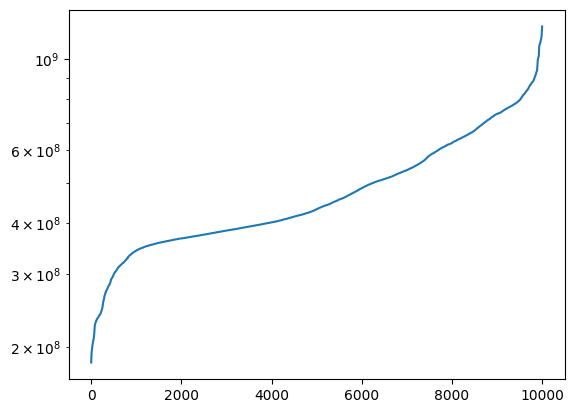

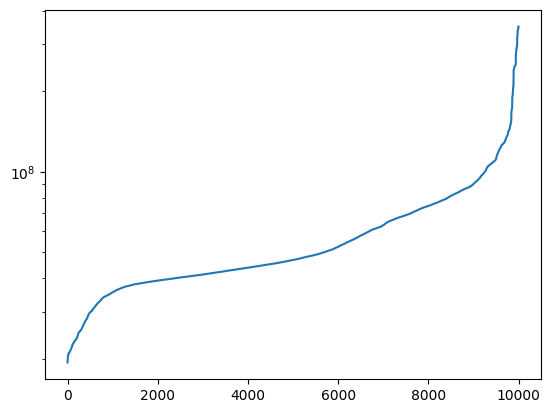

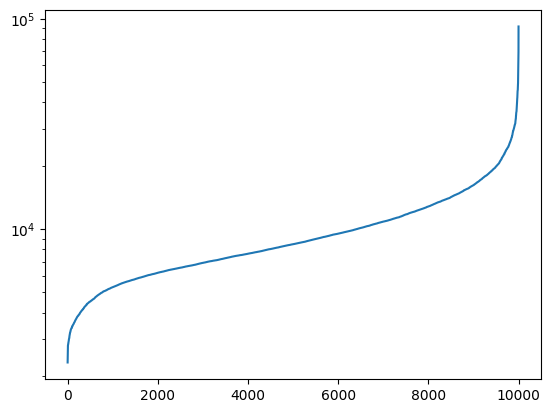

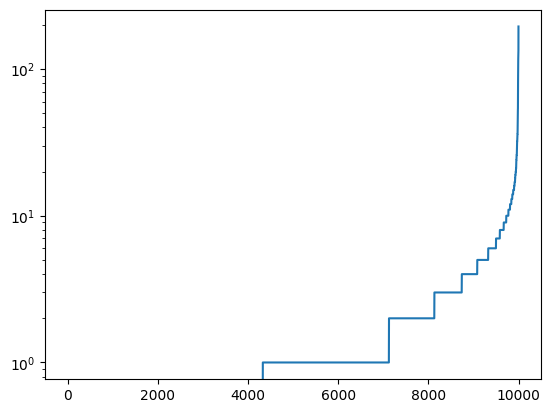

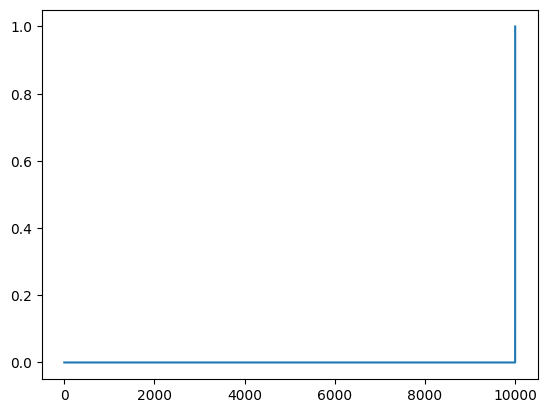

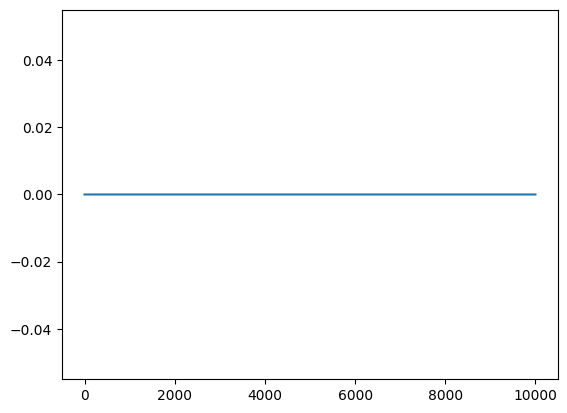

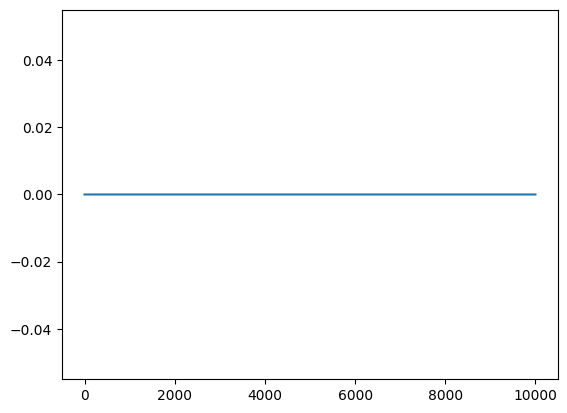

In [38]:
import matplotlib.pyplot as plt

ns.sort()

plt.semilogy(ns)
plt.show()


n0s = []
n1s = []
n2s = []
n3s = []
n4s = []
n5s = []
for i in range(0, len(n_i_lists)):
    n0s.append(np.max(n_i_lists[i][0]))
    n1s.append(np.max(n_i_lists[i][1]))
    n2s.append(np.max(n_i_lists[i][2]))
    n3s.append(np.max(n_i_lists[i][3]))
    n4s.append(np.max(n_i_lists[i][4]))
    n5s.append(np.max(n_i_lists[i][5]))

n0s.sort()
n1s.sort()
n2s.sort()
n3s.sort()
n4s.sort()
n5s.sort()

plt.semilogy(n0s)
plt.show()

plt.semilogy(n1s)
plt.show()

plt.semilogy(n2s)
plt.show()

plt.plot(n3s)
plt.show()

plt.plot(n4s)
plt.show()

plt.plot(n5s)
plt.show()

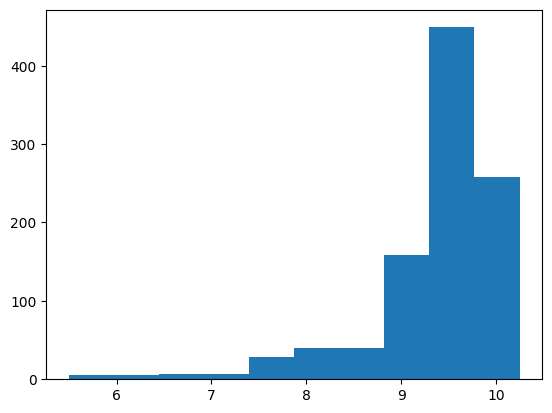

In [35]:
plt.hist(Lifespans)
plt.show()

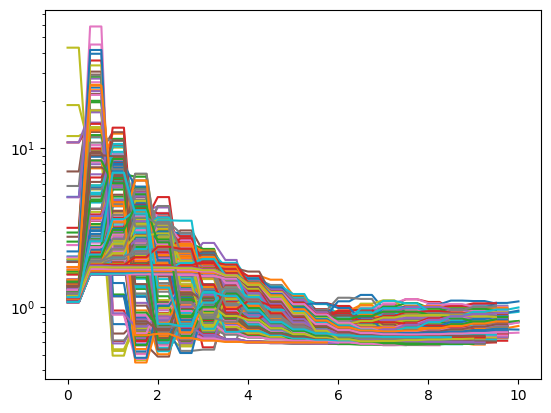

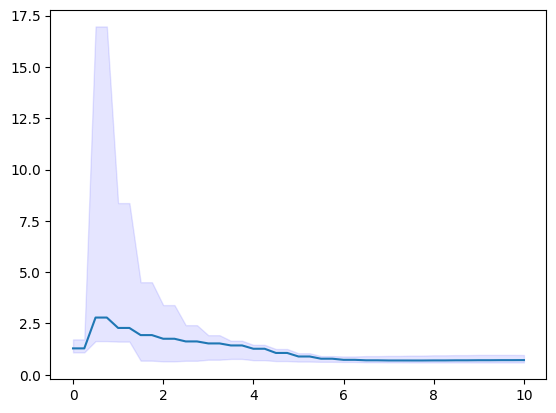

In [48]:
for i in range(0,1000):
    L = Lifespans[i]
    gens = int(L / g)
    plt.semilogy(np.linspace(0, gens * g, gens + 1), r_vals[i][0:gens+1])
plt.show()


#some example data
x = np.linspace(0, 10, 41)
y = np.zeros(41)
ci_u = np.zeros(41)
ci_l = np.zeros(41)
for i in range(0, 41):
    r_i = []
    for j in range(1000):
        r_i.append(r_vals[j][i])
    y[i] = np.mean(np.array(r_i))
    ci_u[i] = np.percentile(np.array(r_i), 97.5)
    ci_l[i] = np.percentile(np.array(r_i), 2.5)


fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (ci_l), (ci_u), color='b', alpha=.1)


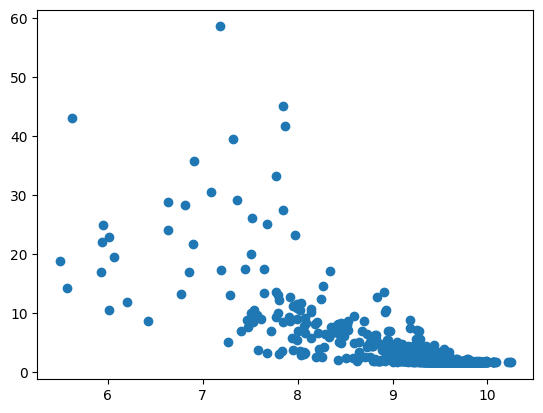

In [ ]:
ma = []
for i in range(0,len(Lifespans)):
    ma.append(max(r_vals[i]))

plt.scatter(Lifespans, ma)


